In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

!pip install catboost
from catboost import CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Load data

In [3]:
DIR  = "/gdrive/MyDrive/Data_Science_Projekte/earth_quake_damage_dd/"

train_values = pd.read_csv(DIR+'data/train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DIR+'data/train_labels.csv', index_col='building_id')
test_values  = pd.read_csv(DIR+"data/test_values.csv", index_col='building_id')
submission_format = pd.read_csv(DIR+"data/submission_format.csv", index_col='building_id')

train_data = train_values.join(train_labels)
train_data.head(5)

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906                    6             487           12198   
28830                     8             900            2812   
94947                    21             363            8973   
590882                   22             418           10694   
201944                   11             131            1488   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
802906                         2   30                6                  5   
28830                          2   10                8                  7   
94947                          2   10                5                  5   
590882                         2   10                6                  5   
201944                         3   30                8                  9   

            land_surface_condition foundation_type roof_type  ...  \
building_id                                                   ...   
802906                           t               r         n  ...   
28830                            o               r         n  ...   
94947                            t               r         n  ...   
590882                           t               r         n  ...   
201944                           t               r         n  ...   

            has_secondary_use_hotel has_secondary_use_rental  \
building_id                                                    
802906                            0                        0   
28830                             0                        0   
94947                             0                        0   
590882                            0                        0   
201944                            0                        0   

            has_secondary_use_institution has_secondary_use_school  \
building_id                                                          
802906                                  0                        0   
28830                                   0                        0   
94947                                   0                        0   
590882                                  0                        0   
201944                                  0                        0   

             has_secondary_use_industry  has_secondary_use_health_post  \
building_id                                                              
802906                                0                              0   
28830                                 0                              0   
94947                                 0                              0   
590882                                0                              0   
201944                                0                              0   

             has_secondary_use_gov_office  has_secondary_use_use_police  \
building_id                                                               
802906                                  0                             0   
28830                                   0                             0   
94947                                   0                             0   
590882                                  0                             0   
201944                                  0                             0   

             has_secondary_use_other  damage_grade  
building_id                                         
802906                             0             3  
28830                              0             2  
94947                              0             3  
590882                             0             2  
201944                             0             3  

[5 rows x 39 columns]

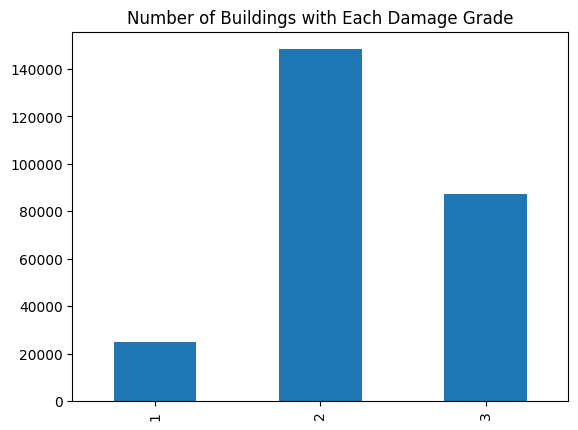

In [4]:
(train_labels.damage_grade.value_counts().sort_index()
    .plot.bar(title="Number of Buildings with Each Damage Grade"))
plt.show()

In [5]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

# Search for best hyperparameters

In [6]:
cat_cols=['geo_level_1_id','geo_level_2_id','geo_level_3_id','land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status','count_floors_pre_eq', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, test_size=0.20)

depth_list = [6, 8]
training_scores=[]
val_scores=[]
best_score=0

for depth in depth_list:
    model = CatBoostClassifier(
        random_seed=42,
        iterations=1000,
        depth=depth,
        eval_metric='TotalF1',
        cat_features=cat_cols,
        verbose=50
    )
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test)
    )

    train_y_pred = model.predict(X_train)
    train_score = f1_score(y_train, train_y_pred, average='micro')
    training_scores.append(train_score)
    print('training score: {0: .3f}'.format(train_score))


    val_y_pred = model.predict(X_test)
    val_score = f1_score(y_test, val_y_pred, average='micro')
    val_scores.append(train_score)
    print('validation score: {0: .3f}'.format(val_score))

    if val_score > best_score:
        best_score = val_score
        best_model = model
        best_depth = depth

Learning rate set to 0.120146
0:	learn: 0.6835199	test: 0.6886876	best: 0.6886876 (0)	total: 2.79s	remaining: 46m 29s
50:	learn: 0.7239447	test: 0.7334825	best: 0.7334825 (50)	total: 1m 35s	remaining: 29m 41s
100:	learn: 0.7301608	test: 0.7386599	best: 0.7387801 (99)	total: 3m 14s	remaining: 28m 54s
150:	learn: 0.7331904	test: 0.7403982	best: 0.7404141 (144)	total: 4m 52s	remaining: 27m 26s
200:	learn: 0.7349158	test: 0.7415829	best: 0.7417046 (196)	total: 6m 33s	remaining: 26m 4s
250:	learn: 0.7364087	test: 0.7416956	best: 0.7418775 (249)	total: 8m 17s	remaining: 24m 43s
300:	learn: 0.7378532	test: 0.7423161	best: 0.7424983 (274)	total: 9m 58s	remaining: 23m 9s
350:	learn: 0.7391065	test: 0.7428962	best: 0.7430300 (349)	total: 11m 40s	remaining: 21m 35s
400:	learn: 0.7405028	test: 0.7430553	best: 0.7435683 (376)	total: 13m 23s	remaining: 20m
450:	learn: 0.7414046	test: 0.7435285	best: 0.7436981 (445)	total: 15m 5s	remaining: 18m 21s
500:	learn: 0.7421929	test: 0.7434360	best: 0.743698

# Final training and prediction

In [10]:
model = CatBoostClassifier(
    random_seed=42,
    iterations=1000,
    depth=best_depth,
    eval_metric='TotalF1',
    cat_features=cat_cols,
    verbose=50
)
model.fit(
    train_values, train_labels,
)

train_y_pred = model.predict(train_values)
train_score = f1_score(train_labels, train_y_pred, average='micro')
print('training score: {0: .3f}'.format(train_score))

Learning rate set to 0.105084
0:	learn: 0.6916499	total: 8.72s	remaining: 2h 25m 13s
50:	learn: 0.7283761	total: 3m 33s	remaining: 1h 6m 13s
100:	learn: 0.7343230	total: 7m 42s	remaining: 1h 8m 37s
150:	learn: 0.7387228	total: 11m 48s	remaining: 1h 6m 22s
200:	learn: 0.7416945	total: 15m 55s	remaining: 1h 3m 19s
250:	learn: 0.7437957	total: 20m 7s	remaining: 1h 2s
300:	learn: 0.7461008	total: 24m 19s	remaining: 56m 30s
350:	learn: 0.7477422	total: 28m 36s	remaining: 52m 53s
400:	learn: 0.7494708	total: 32m 49s	remaining: 49m 2s
450:	learn: 0.7512846	total: 36m 58s	remaining: 44m 59s
500:	learn: 0.7524459	total: 41m 17s	remaining: 41m 7s
550:	learn: 0.7545069	total: 45m 32s	remaining: 37m 6s
600:	learn: 0.7557985	total: 49m 46s	remaining: 33m 2s
650:	learn: 0.7575617	total: 54m 1s	remaining: 28m 57s
700:	learn: 0.7590403	total: 58m 15s	remaining: 24m 51s
750:	learn: 0.7604997	total: 1h 2m 31s	remaining: 20m 43s
800:	learn: 0.7619926	total: 1h 6m 50s	remaining: 16m 36s
850:	learn: 0.7630

In [11]:
predictions = model.predict(test_values)

# Save submission

In [12]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [13]:
my_submission.head()

damage_grade
building_id              
300051                  3
99355                   2
890251                  2
745817                  1
421793                  3

In [15]:
my_submission.to_csv(DIR+'submissions/submission_first.csv')